In [1]:
import pennylane as qml
import numpy as np
from numpy.random import randn, randint
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
import math
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

# Data

In [2]:
# Number training data samples
N = 10000

data_1 = np.random.normal(5, 1.2, size=6000000)
data_2 = np.random.normal(10, 1.5, size=4000000)

data = shuffle(np.concatenate((data_1, data_2)))

In [3]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([1.050000e+02, 2.494000e+03, 3.471100e+04, 2.500480e+05,
        9.279010e+05, 1.785734e+06, 1.799474e+06, 1.003216e+06,
        5.232390e+05, 6.790630e+05, 9.923220e+05, 9.917840e+05,
        6.458950e+05, 2.732720e+05, 7.544800e+04, 1.529400e+04]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15.]),
 <BarContainer object of 16 artists>)

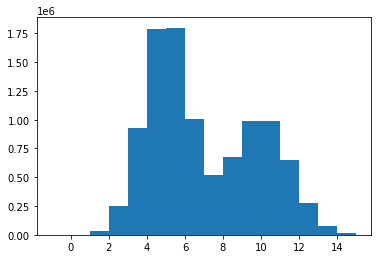

In [4]:
plt.hist(bin_indices, bins = 16)

In [5]:
data_process = []
for i in range(int(N/10)):
    idx = np.random.randint(N, size=1000)
    temp = data_temp[idx]
    new_point = np.sum(temp, axis = 0)/1000
    data_process.append(new_point)
data_processed = np.array(data_process)

# Networks

## Discriminator

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 

    return model

## Generator

In [7]:
n_qubits = 4
q_depth = 3

In [8]:
dev = qml.device("default.qubit", wires= n_qubits, shots = 10000)

In [9]:
@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    #qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    
    # Init distribution
    for a in range(n_qubits):
        qml.Hadamard(wires=a)
    
    # Actual distribution
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[2*(i*n_qubits + j) ], wires=j)
            qml.RZ(weights[2*(i*n_qubits + j) + 1], wires=j)
            if (j == (n_qubits - 1)):
                qml.CNOT(wires=[j,0])
            else:
                qml.CNOT(wires=[j,j+1])
    
    for k in range(n_qubits):
        qml.RY(weights[(2*q_depth * n_qubits) + k ], wires=k)
        qml.RZ(weights[(2*q_depth * n_qubits) + k + 1], wires=k)
    
    return qml.probs(wires=range(n_qubits))

In [10]:
weight_shapes = {"weights": (2*(q_depth +1) * n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=16)

In [11]:
def make_generator_model():
    in_lat = tf.keras.Input(shape=(4, ))
    gen = qlayer(in_lat)
    
    model = tf.keras.Model(in_lat, gen)

    return model

In [12]:
gen = make_generator_model()

In [13]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model(gen_output)
    # define gan model as taking noise and label and outputting a classification
    model = tf.keras.Model(gen_noise, gan_output)
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
generator = make_generator_model()
discriminator = make_discriminator_model()
gan_model = define_gan(generator, discriminator)

In [15]:
generator.input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'input_2')>

In [16]:
noise = tf.random.normal([100, 4])

In [17]:
generator.predict(noise)

array([[0.0293, 0.0432, 0.0022, ..., 0.0849, 0.062 , 0.0365],
       [0.0316, 0.041 , 0.0026, ..., 0.0906, 0.0688, 0.0356],
       [0.0309, 0.0417, 0.0032, ..., 0.0846, 0.068 , 0.0333],
       ...,
       [0.0308, 0.0422, 0.0035, ..., 0.0827, 0.0646, 0.0353],
       [0.0291, 0.0417, 0.0035, ..., 0.0837, 0.0686, 0.0335],
       [0.0315, 0.043 , 0.0029, ..., 0.0858, 0.0642, 0.0352]],
      dtype=float32)

In [18]:
gan_model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

# Train

In [19]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images and labels
    X = dataset[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return X, y

In [20]:
def generate_fake_samples(generator, n_samples):
    noise = tf.random.normal([n_samples, 4])
    # predict outputs
    outputs = generator.predict(noise)
    # create class labels
    y = np.zeros((n_samples, 1))
    return outputs, y

In [21]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, n_epochs=200, n_batch=200):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    seed = tf.random.normal([1, 4])
    # manually enumerate epochs
    for i in range(n_epochs):
        if (i % 10 == 0): 
            test_data = generator.predict(seed)
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            y = range(16)
            ax.bar(y, test_data[0] )
            plt.show()
            
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            z_input = tf.random.normal([n_batch, 4])
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss, _ = gan_model.train_on_batch(z_input, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))


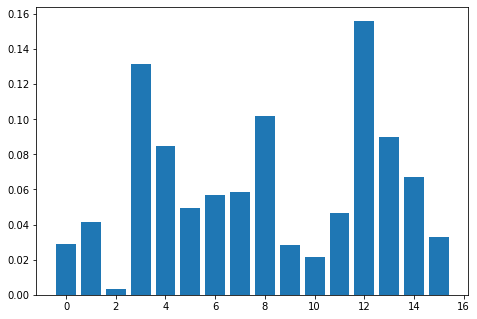

>1, 1/20, d1=0.700, d2=0.698 g=0.691
>1, 2/20, d1=0.701, d2=0.696 g=0.693
>1, 3/20, d1=0.695, d2=0.695 g=0.692
>1, 4/20, d1=0.696, d2=0.697 g=0.692
>1, 5/20, d1=0.701, d2=0.694 g=0.691
>1, 6/20, d1=0.697, d2=0.693 g=0.693
>1, 7/20, d1=0.691, d2=0.695 g=0.689
>1, 8/20, d1=0.689, d2=0.692 g=0.692
>1, 9/20, d1=0.687, d2=0.692 g=0.693
>1, 10/20, d1=0.686, d2=0.691 g=0.693
>1, 11/20, d1=0.693, d2=0.694 g=0.694
>1, 12/20, d1=0.686, d2=0.692 g=0.695
>1, 13/20, d1=0.693, d2=0.694 g=0.692
>1, 14/20, d1=0.686, d2=0.691 g=0.692
>1, 15/20, d1=0.687, d2=0.690 g=0.693
>1, 16/20, d1=0.690, d2=0.697 g=0.695
>1, 17/20, d1=0.686, d2=0.697 g=0.695
>1, 18/20, d1=0.688, d2=0.694 g=0.691
>1, 19/20, d1=0.679, d2=0.691 g=0.693
>1, 20/20, d1=0.689, d2=0.689 g=0.691
>2, 1/20, d1=0.685, d2=0.689 g=0.694
>2, 2/20, d1=0.685, d2=0.693 g=0.693
>2, 3/20, d1=0.682, d2=0.688 g=0.696
>2, 4/20, d1=0.684, d2=0.690 g=0.694
>2, 5/20, d1=0.684, d2=0.695 g=0.695
>2, 6/20, d1=0.679, d2=0.695 g=0.693
>2, 7/20, d1=0.681, d2=0.69

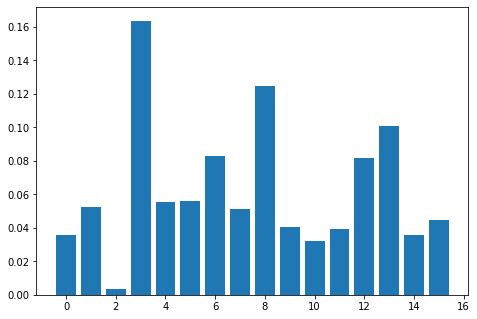

>11, 1/20, d1=0.572, d2=0.652 g=0.741
>11, 2/20, d1=0.576, d2=0.645 g=0.741
>11, 3/20, d1=0.576, d2=0.653 g=0.742
>11, 4/20, d1=0.546, d2=0.659 g=0.745
>11, 5/20, d1=0.567, d2=0.654 g=0.738
>11, 6/20, d1=0.578, d2=0.650 g=0.742
>11, 7/20, d1=0.571, d2=0.644 g=0.741
>11, 8/20, d1=0.571, d2=0.658 g=0.742
>11, 9/20, d1=0.571, d2=0.637 g=0.745
>11, 10/20, d1=0.566, d2=0.641 g=0.746
>11, 11/20, d1=0.561, d2=0.632 g=0.748
>11, 12/20, d1=0.570, d2=0.632 g=0.744
>11, 13/20, d1=0.564, d2=0.639 g=0.746
>11, 14/20, d1=0.556, d2=0.640 g=0.749
>11, 15/20, d1=0.568, d2=0.636 g=0.749
>11, 16/20, d1=0.539, d2=0.644 g=0.747
>11, 17/20, d1=0.566, d2=0.647 g=0.756
>11, 18/20, d1=0.565, d2=0.637 g=0.754
>11, 19/20, d1=0.557, d2=0.646 g=0.754
>11, 20/20, d1=0.567, d2=0.634 g=0.760
>12, 1/20, d1=0.558, d2=0.636 g=0.763
>12, 2/20, d1=0.554, d2=0.638 g=0.751
>12, 3/20, d1=0.557, d2=0.637 g=0.767
>12, 4/20, d1=0.559, d2=0.633 g=0.762
>12, 5/20, d1=0.563, d2=0.629 g=0.760
>12, 6/20, d1=0.569, d2=0.634 g=0.754
>

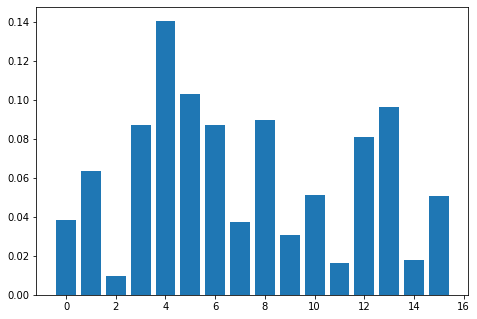

>21, 1/20, d1=0.427, d2=0.522 g=0.934
>21, 2/20, d1=0.397, d2=0.510 g=0.914
>21, 3/20, d1=0.412, d2=0.512 g=0.922
>21, 4/20, d1=0.417, d2=0.504 g=0.924
>21, 5/20, d1=0.411, d2=0.512 g=0.912
>21, 6/20, d1=0.402, d2=0.514 g=0.913
>21, 7/20, d1=0.389, d2=0.497 g=0.910
>21, 8/20, d1=0.371, d2=0.505 g=0.925
>21, 9/20, d1=0.406, d2=0.505 g=0.915
>21, 10/20, d1=0.419, d2=0.493 g=0.926
>21, 11/20, d1=0.396, d2=0.503 g=0.925
>21, 12/20, d1=0.427, d2=0.513 g=0.941
>21, 13/20, d1=0.383, d2=0.529 g=0.955
>21, 14/20, d1=0.414, d2=0.503 g=0.929
>21, 15/20, d1=0.376, d2=0.507 g=0.953
>21, 16/20, d1=0.419, d2=0.513 g=0.944
>21, 17/20, d1=0.387, d2=0.514 g=0.940
>21, 18/20, d1=0.395, d2=0.488 g=0.936
>21, 19/20, d1=0.387, d2=0.500 g=0.944
>21, 20/20, d1=0.395, d2=0.488 g=0.934
>22, 1/20, d1=0.400, d2=0.517 g=0.938
>22, 2/20, d1=0.388, d2=0.492 g=0.952
>22, 3/20, d1=0.378, d2=0.520 g=0.908
>22, 4/20, d1=0.404, d2=0.513 g=0.942
>22, 5/20, d1=0.387, d2=0.514 g=0.941
>22, 6/20, d1=0.407, d2=0.504 g=0.966
>

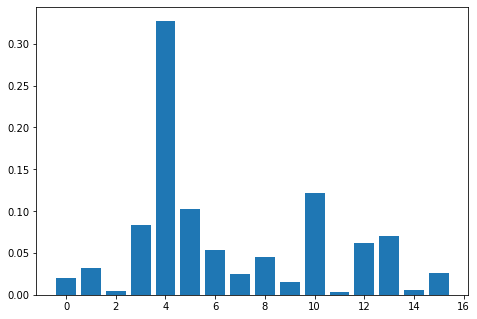

>31, 1/20, d1=0.385, d2=0.498 g=1.020
>31, 2/20, d1=0.368, d2=0.477 g=0.965
>31, 3/20, d1=0.398, d2=0.460 g=0.957
>31, 4/20, d1=0.394, d2=0.523 g=0.941
>31, 5/20, d1=0.377, d2=0.486 g=0.961
>31, 6/20, d1=0.388, d2=0.515 g=0.948
>31, 7/20, d1=0.374, d2=0.482 g=1.011
>31, 8/20, d1=0.387, d2=0.495 g=0.968
>31, 9/20, d1=0.362, d2=0.480 g=0.960
>31, 10/20, d1=0.363, d2=0.479 g=0.957
>31, 11/20, d1=0.362, d2=0.501 g=0.977
>31, 12/20, d1=0.381, d2=0.488 g=1.005
>31, 13/20, d1=0.381, d2=0.472 g=0.977
>31, 14/20, d1=0.345, d2=0.473 g=0.978
>31, 15/20, d1=0.367, d2=0.498 g=0.992
>31, 16/20, d1=0.394, d2=0.507 g=0.977
>31, 17/20, d1=0.393, d2=0.502 g=0.955
>31, 18/20, d1=0.371, d2=0.539 g=0.952
>31, 19/20, d1=0.385, d2=0.504 g=0.991
>31, 20/20, d1=0.374, d2=0.518 g=0.973
>32, 1/20, d1=0.409, d2=0.508 g=0.989
>32, 2/20, d1=0.376, d2=0.477 g=0.958
>32, 3/20, d1=0.347, d2=0.474 g=0.986
>32, 4/20, d1=0.407, d2=0.508 g=0.935
>32, 5/20, d1=0.363, d2=0.466 g=0.949
>32, 6/20, d1=0.395, d2=0.490 g=0.987
>

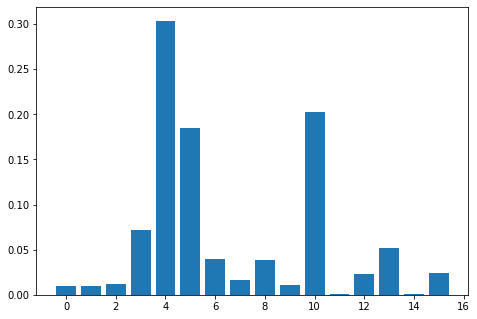

>41, 1/20, d1=0.379, d2=0.462 g=1.003
>41, 2/20, d1=0.393, d2=0.464 g=1.015
>41, 3/20, d1=0.401, d2=0.490 g=1.058
>41, 4/20, d1=0.400, d2=0.462 g=1.036
>41, 5/20, d1=0.348, d2=0.437 g=1.046
>41, 6/20, d1=0.382, d2=0.491 g=1.010
>41, 7/20, d1=0.412, d2=0.449 g=1.021
>41, 8/20, d1=0.398, d2=0.444 g=1.028
>41, 9/20, d1=0.391, d2=0.427 g=1.032
>41, 10/20, d1=0.382, d2=0.447 g=1.031
>41, 11/20, d1=0.360, d2=0.471 g=1.011
>41, 12/20, d1=0.373, d2=0.447 g=1.028
>41, 13/20, d1=0.373, d2=0.431 g=1.032
>41, 14/20, d1=0.391, d2=0.445 g=1.051
>41, 15/20, d1=0.388, d2=0.450 g=1.029
>41, 16/20, d1=0.414, d2=0.451 g=1.027
>41, 17/20, d1=0.397, d2=0.482 g=1.066
>41, 18/20, d1=0.355, d2=0.437 g=1.003
>41, 19/20, d1=0.393, d2=0.436 g=1.055
>41, 20/20, d1=0.369, d2=0.465 g=1.071
>42, 1/20, d1=0.364, d2=0.450 g=1.013
>42, 2/20, d1=0.357, d2=0.426 g=1.009
>42, 3/20, d1=0.369, d2=0.457 g=1.072
>42, 4/20, d1=0.368, d2=0.436 g=1.048
>42, 5/20, d1=0.380, d2=0.452 g=1.013
>42, 6/20, d1=0.403, d2=0.418 g=1.028
>

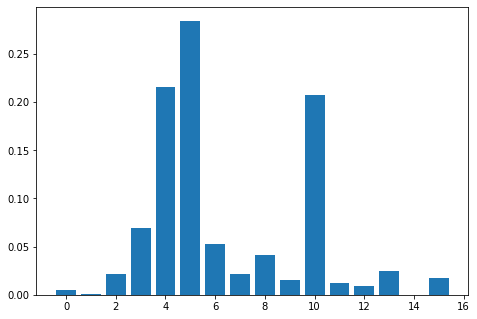

>51, 1/20, d1=0.396, d2=0.443 g=1.042
>51, 2/20, d1=0.391, d2=0.447 g=1.035
>51, 3/20, d1=0.380, d2=0.506 g=1.063
>51, 4/20, d1=0.409, d2=0.476 g=1.053
>51, 5/20, d1=0.372, d2=0.476 g=1.079
>51, 6/20, d1=0.375, d2=0.509 g=1.042
>51, 7/20, d1=0.361, d2=0.453 g=1.044
>51, 8/20, d1=0.393, d2=0.467 g=1.068
>51, 9/20, d1=0.377, d2=0.488 g=1.006
>51, 10/20, d1=0.395, d2=0.483 g=1.070
>51, 11/20, d1=0.387, d2=0.500 g=1.004
>51, 12/20, d1=0.380, d2=0.430 g=1.052
>51, 13/20, d1=0.360, d2=0.495 g=1.034
>51, 14/20, d1=0.389, d2=0.471 g=1.052
>51, 15/20, d1=0.366, d2=0.445 g=1.009
>51, 16/20, d1=0.380, d2=0.510 g=1.048
>51, 17/20, d1=0.347, d2=0.460 g=1.039
>51, 18/20, d1=0.410, d2=0.445 g=1.040
>51, 19/20, d1=0.349, d2=0.439 g=1.013
>51, 20/20, d1=0.386, d2=0.422 g=1.032
>52, 1/20, d1=0.385, d2=0.487 g=0.995
>52, 2/20, d1=0.386, d2=0.517 g=1.018
>52, 3/20, d1=0.398, d2=0.481 g=1.008
>52, 4/20, d1=0.408, d2=0.478 g=1.058
>52, 5/20, d1=0.385, d2=0.442 g=1.051
>52, 6/20, d1=0.368, d2=0.514 g=0.999
>

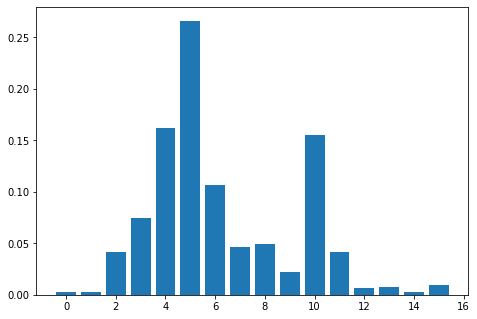

>61, 1/20, d1=0.500, d2=0.585 g=0.975
>61, 2/20, d1=0.465, d2=0.531 g=0.995
>61, 3/20, d1=0.435, d2=0.520 g=0.999
>61, 4/20, d1=0.410, d2=0.515 g=0.922
>61, 5/20, d1=0.447, d2=0.479 g=1.016
>61, 6/20, d1=0.463, d2=0.495 g=0.970
>61, 7/20, d1=0.442, d2=0.524 g=1.021
>61, 8/20, d1=0.481, d2=0.508 g=0.944
>61, 9/20, d1=0.433, d2=0.510 g=0.968
>61, 10/20, d1=0.436, d2=0.545 g=0.976
>61, 11/20, d1=0.453, d2=0.524 g=0.917
>61, 12/20, d1=0.466, d2=0.521 g=0.954
>61, 13/20, d1=0.447, d2=0.525 g=0.925
>61, 14/20, d1=0.422, d2=0.494 g=0.990
>61, 15/20, d1=0.446, d2=0.535 g=1.003
>61, 16/20, d1=0.467, d2=0.509 g=0.973
>61, 17/20, d1=0.425, d2=0.545 g=0.951
>61, 18/20, d1=0.450, d2=0.535 g=0.876
>61, 19/20, d1=0.433, d2=0.527 g=0.917
>61, 20/20, d1=0.477, d2=0.489 g=0.943
>62, 1/20, d1=0.434, d2=0.486 g=0.975
>62, 2/20, d1=0.420, d2=0.567 g=0.954
>62, 3/20, d1=0.484, d2=0.562 g=0.865
>62, 4/20, d1=0.496, d2=0.555 g=0.959
>62, 5/20, d1=0.448, d2=0.514 g=0.966
>62, 6/20, d1=0.445, d2=0.571 g=0.933
>

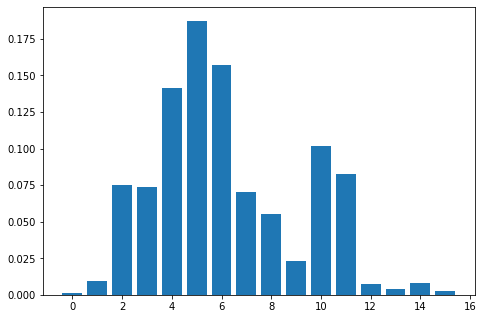

>71, 1/20, d1=0.509, d2=0.606 g=0.831
>71, 2/20, d1=0.565, d2=0.579 g=0.829
>71, 3/20, d1=0.490, d2=0.577 g=0.915
>71, 4/20, d1=0.556, d2=0.602 g=0.820
>71, 5/20, d1=0.519, d2=0.650 g=0.892
>71, 6/20, d1=0.525, d2=0.634 g=0.830
>71, 7/20, d1=0.541, d2=0.593 g=0.840
>71, 8/20, d1=0.582, d2=0.539 g=0.881
>71, 9/20, d1=0.504, d2=0.605 g=0.850
>71, 10/20, d1=0.484, d2=0.535 g=0.867
>71, 11/20, d1=0.535, d2=0.591 g=0.877
>71, 12/20, d1=0.510, d2=0.549 g=0.874
>71, 13/20, d1=0.528, d2=0.543 g=0.796
>71, 14/20, d1=0.495, d2=0.553 g=0.840
>71, 15/20, d1=0.522, d2=0.626 g=0.865
>71, 16/20, d1=0.493, d2=0.595 g=0.897
>71, 17/20, d1=0.466, d2=0.566 g=0.920
>71, 18/20, d1=0.474, d2=0.597 g=0.863
>71, 19/20, d1=0.567, d2=0.558 g=0.866
>71, 20/20, d1=0.490, d2=0.637 g=0.869
>72, 1/20, d1=0.540, d2=0.649 g=0.826
>72, 2/20, d1=0.509, d2=0.581 g=0.810
>72, 3/20, d1=0.520, d2=0.576 g=0.830
>72, 4/20, d1=0.498, d2=0.581 g=0.857
>72, 5/20, d1=0.529, d2=0.583 g=0.885
>72, 6/20, d1=0.519, d2=0.577 g=0.854
>

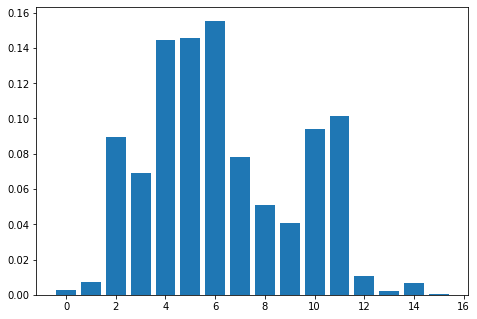

>81, 1/20, d1=0.526, d2=0.563 g=0.791
>81, 2/20, d1=0.524, d2=0.539 g=0.882
>81, 3/20, d1=0.458, d2=0.569 g=0.821
>81, 4/20, d1=0.518, d2=0.598 g=0.868
>81, 5/20, d1=0.541, d2=0.585 g=0.833
>81, 6/20, d1=0.498, d2=0.635 g=0.844
>81, 7/20, d1=0.541, d2=0.639 g=0.851
>81, 8/20, d1=0.555, d2=0.615 g=0.828
>81, 9/20, d1=0.592, d2=0.624 g=0.859
>81, 10/20, d1=0.594, d2=0.619 g=0.835
>81, 11/20, d1=0.538, d2=0.662 g=0.818
>81, 12/20, d1=0.519, d2=0.604 g=0.811
>81, 13/20, d1=0.525, d2=0.563 g=0.831
>81, 14/20, d1=0.558, d2=0.577 g=0.832
>81, 15/20, d1=0.554, d2=0.656 g=0.879
>81, 16/20, d1=0.612, d2=0.610 g=0.856
>81, 17/20, d1=0.512, d2=0.577 g=0.876
>81, 18/20, d1=0.519, d2=0.641 g=0.824
>81, 19/20, d1=0.553, d2=0.596 g=0.853
>81, 20/20, d1=0.582, d2=0.618 g=0.818
>82, 1/20, d1=0.594, d2=0.599 g=0.842
>82, 2/20, d1=0.500, d2=0.614 g=0.887
>82, 3/20, d1=0.582, d2=0.589 g=0.912
>82, 4/20, d1=0.499, d2=0.529 g=0.849
>82, 5/20, d1=0.538, d2=0.610 g=0.882
>82, 6/20, d1=0.523, d2=0.586 g=0.865
>

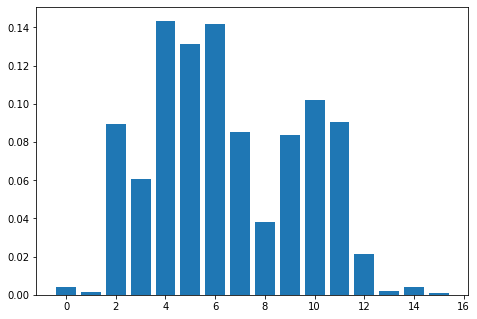

>91, 1/20, d1=0.595, d2=0.637 g=0.750
>91, 2/20, d1=0.576, d2=0.666 g=0.745
>91, 3/20, d1=0.610, d2=0.600 g=0.736
>91, 4/20, d1=0.576, d2=0.660 g=0.758
>91, 5/20, d1=0.613, d2=0.648 g=0.777
>91, 6/20, d1=0.599, d2=0.658 g=0.720
>91, 7/20, d1=0.587, d2=0.687 g=0.741
>91, 8/20, d1=0.656, d2=0.631 g=0.761
>91, 9/20, d1=0.557, d2=0.635 g=0.744
>91, 10/20, d1=0.597, d2=0.713 g=0.765
>91, 11/20, d1=0.516, d2=0.662 g=0.755
>91, 12/20, d1=0.572, d2=0.675 g=0.706
>91, 13/20, d1=0.565, d2=0.727 g=0.771
>91, 14/20, d1=0.574, d2=0.671 g=0.741
>91, 15/20, d1=0.558, d2=0.654 g=0.707
>91, 16/20, d1=0.612, d2=0.749 g=0.749
>91, 17/20, d1=0.654, d2=0.678 g=0.743
>91, 18/20, d1=0.589, d2=0.731 g=0.723
>91, 19/20, d1=0.611, d2=0.703 g=0.765
>91, 20/20, d1=0.577, d2=0.625 g=0.760
>92, 1/20, d1=0.627, d2=0.663 g=0.731
>92, 2/20, d1=0.577, d2=0.680 g=0.727
>92, 3/20, d1=0.587, d2=0.697 g=0.747
>92, 4/20, d1=0.598, d2=0.629 g=0.750
>92, 5/20, d1=0.627, d2=0.647 g=0.750
>92, 6/20, d1=0.574, d2=0.673 g=0.710
>

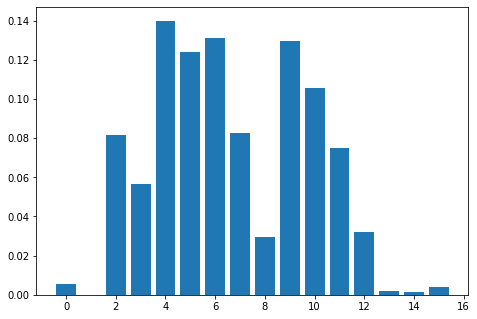

>101, 1/20, d1=0.727, d2=0.760 g=0.660
>101, 2/20, d1=0.628, d2=0.679 g=0.686
>101, 3/20, d1=0.658, d2=0.825 g=0.686
>101, 4/20, d1=0.579, d2=0.752 g=0.680
>101, 5/20, d1=0.619, d2=0.671 g=0.680
>101, 6/20, d1=0.600, d2=0.797 g=0.699
>101, 7/20, d1=0.609, d2=0.740 g=0.657
>101, 8/20, d1=0.613, d2=0.716 g=0.658
>101, 9/20, d1=0.640, d2=0.727 g=0.654
>101, 10/20, d1=0.669, d2=0.703 g=0.632
>101, 11/20, d1=0.626, d2=0.682 g=0.689
>101, 12/20, d1=0.631, d2=0.669 g=0.696
>101, 13/20, d1=0.711, d2=0.744 g=0.662
>101, 14/20, d1=0.682, d2=0.712 g=0.680
>101, 15/20, d1=0.618, d2=0.709 g=0.690
>101, 16/20, d1=0.639, d2=0.735 g=0.702
>101, 17/20, d1=0.661, d2=0.784 g=0.666
>101, 18/20, d1=0.607, d2=0.750 g=0.675
>101, 19/20, d1=0.617, d2=0.719 g=0.664
>101, 20/20, d1=0.694, d2=0.722 g=0.690
>102, 1/20, d1=0.663, d2=0.728 g=0.693
>102, 2/20, d1=0.646, d2=0.758 g=0.667
>102, 3/20, d1=0.608, d2=0.751 g=0.695
>102, 4/20, d1=0.614, d2=0.714 g=0.680
>102, 5/20, d1=0.656, d2=0.757 g=0.609
>102, 6/20, d1

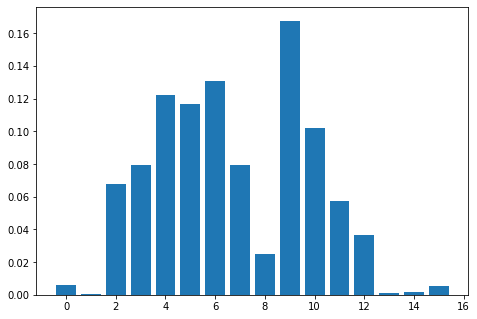

>111, 1/20, d1=0.664, d2=0.663 g=0.636
>111, 2/20, d1=0.630, d2=0.706 g=0.669
>111, 3/20, d1=0.663, d2=0.669 g=0.679
>111, 4/20, d1=0.615, d2=0.769 g=0.655
>111, 5/20, d1=0.662, d2=0.771 g=0.670
>111, 6/20, d1=0.677, d2=0.751 g=0.665
>111, 7/20, d1=0.680, d2=0.725 g=0.676
>111, 8/20, d1=0.671, d2=0.762 g=0.671
>111, 9/20, d1=0.659, d2=0.751 g=0.696
>111, 10/20, d1=0.592, d2=0.727 g=0.620
>111, 11/20, d1=0.631, d2=0.739 g=0.672
>111, 12/20, d1=0.643, d2=0.789 g=0.654
>111, 13/20, d1=0.608, d2=0.708 g=0.672
>111, 14/20, d1=0.636, d2=0.737 g=0.715
>111, 15/20, d1=0.686, d2=0.710 g=0.701
>111, 16/20, d1=0.631, d2=0.768 g=0.665
>111, 17/20, d1=0.648, d2=0.764 g=0.665
>111, 18/20, d1=0.623, d2=0.761 g=0.696
>111, 19/20, d1=0.640, d2=0.740 g=0.633
>111, 20/20, d1=0.658, d2=0.750 g=0.701
>112, 1/20, d1=0.670, d2=0.749 g=0.665
>112, 2/20, d1=0.677, d2=0.748 g=0.711
>112, 3/20, d1=0.667, d2=0.706 g=0.687
>112, 4/20, d1=0.638, d2=0.758 g=0.670
>112, 5/20, d1=0.691, d2=0.701 g=0.650
>112, 6/20, d1

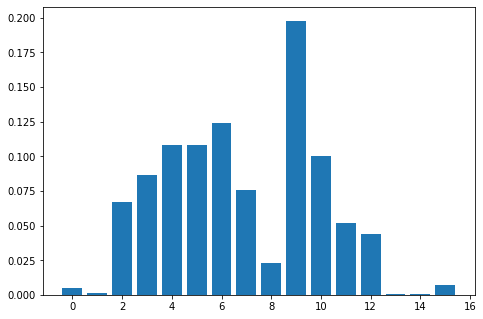

>121, 1/20, d1=0.589, d2=0.733 g=0.688
>121, 2/20, d1=0.579, d2=0.701 g=0.685
>121, 3/20, d1=0.646, d2=0.709 g=0.727
>121, 4/20, d1=0.604, d2=0.740 g=0.706
>121, 5/20, d1=0.665, d2=0.712 g=0.746
>121, 6/20, d1=0.627, d2=0.735 g=0.681
>121, 7/20, d1=0.602, d2=0.678 g=0.749
>121, 8/20, d1=0.627, d2=0.787 g=0.724
>121, 9/20, d1=0.597, d2=0.665 g=0.754
>121, 10/20, d1=0.630, d2=0.739 g=0.693
>121, 11/20, d1=0.581, d2=0.703 g=0.752
>121, 12/20, d1=0.604, d2=0.732 g=0.679
>121, 13/20, d1=0.653, d2=0.762 g=0.715
>121, 14/20, d1=0.659, d2=0.678 g=0.741
>121, 15/20, d1=0.572, d2=0.668 g=0.700
>121, 16/20, d1=0.566, d2=0.686 g=0.681
>121, 17/20, d1=0.620, d2=0.711 g=0.695
>121, 18/20, d1=0.641, d2=0.681 g=0.713
>121, 19/20, d1=0.639, d2=0.690 g=0.730
>121, 20/20, d1=0.587, d2=0.709 g=0.735
>122, 1/20, d1=0.643, d2=0.660 g=0.723
>122, 2/20, d1=0.580, d2=0.673 g=0.714
>122, 3/20, d1=0.597, d2=0.721 g=0.701
>122, 4/20, d1=0.653, d2=0.711 g=0.720
>122, 5/20, d1=0.615, d2=0.696 g=0.744
>122, 6/20, d1

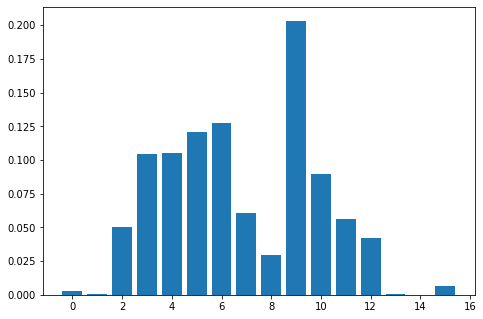

>131, 1/20, d1=0.572, d2=0.718 g=0.763
>131, 2/20, d1=0.617, d2=0.643 g=0.780
>131, 3/20, d1=0.609, d2=0.656 g=0.765
>131, 4/20, d1=0.616, d2=0.645 g=0.735
>131, 5/20, d1=0.635, d2=0.628 g=0.757
>131, 6/20, d1=0.592, d2=0.620 g=0.727
>131, 7/20, d1=0.593, d2=0.647 g=0.723
>131, 8/20, d1=0.573, d2=0.681 g=0.727
>131, 9/20, d1=0.621, d2=0.650 g=0.745
>131, 10/20, d1=0.640, d2=0.665 g=0.733
>131, 11/20, d1=0.542, d2=0.638 g=0.751
>131, 12/20, d1=0.584, d2=0.685 g=0.752
>131, 13/20, d1=0.629, d2=0.651 g=0.718
>131, 14/20, d1=0.609, d2=0.663 g=0.729
>131, 15/20, d1=0.615, d2=0.678 g=0.732
>131, 16/20, d1=0.565, d2=0.673 g=0.722
>131, 17/20, d1=0.602, d2=0.657 g=0.758
>131, 18/20, d1=0.572, d2=0.649 g=0.766
>131, 19/20, d1=0.636, d2=0.692 g=0.810
>131, 20/20, d1=0.661, d2=0.663 g=0.715
>132, 1/20, d1=0.656, d2=0.618 g=0.753
>132, 2/20, d1=0.617, d2=0.661 g=0.754
>132, 3/20, d1=0.547, d2=0.696 g=0.756
>132, 4/20, d1=0.586, d2=0.658 g=0.734
>132, 5/20, d1=0.655, d2=0.685 g=0.739
>132, 6/20, d1

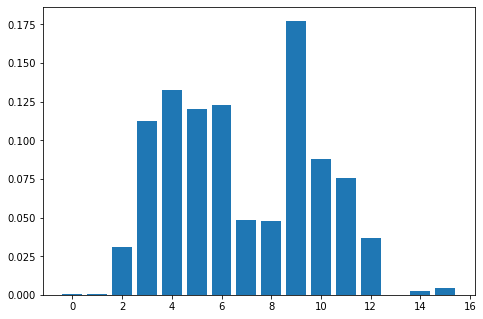

>141, 1/20, d1=0.625, d2=0.704 g=0.697
>141, 2/20, d1=0.556, d2=0.685 g=0.699
>141, 3/20, d1=0.622, d2=0.665 g=0.723
>141, 4/20, d1=0.602, d2=0.689 g=0.738
>141, 5/20, d1=0.619, d2=0.759 g=0.720
>141, 6/20, d1=0.643, d2=0.625 g=0.711
>141, 7/20, d1=0.572, d2=0.670 g=0.724
>141, 8/20, d1=0.616, d2=0.695 g=0.702
>141, 9/20, d1=0.608, d2=0.711 g=0.715
>141, 10/20, d1=0.573, d2=0.696 g=0.737
>141, 11/20, d1=0.603, d2=0.719 g=0.783
>141, 12/20, d1=0.606, d2=0.693 g=0.719
>141, 13/20, d1=0.550, d2=0.715 g=0.715
>141, 14/20, d1=0.553, d2=0.699 g=0.710
>141, 15/20, d1=0.656, d2=0.677 g=0.777
>141, 16/20, d1=0.559, d2=0.628 g=0.695
>141, 17/20, d1=0.626, d2=0.691 g=0.760
>141, 18/20, d1=0.571, d2=0.709 g=0.729
>141, 19/20, d1=0.645, d2=0.735 g=0.741
>141, 20/20, d1=0.616, d2=0.737 g=0.708
>142, 1/20, d1=0.614, d2=0.688 g=0.702
>142, 2/20, d1=0.620, d2=0.709 g=0.763
>142, 3/20, d1=0.616, d2=0.693 g=0.744
>142, 4/20, d1=0.627, d2=0.634 g=0.703
>142, 5/20, d1=0.646, d2=0.709 g=0.705
>142, 6/20, d1

In [22]:
train(generator, discriminator, gan_model, data_processed, n_epochs=150, n_batch=50)

In [24]:
noise = tf.random.normal([1, 4])
generated_data = generator(noise, training=False).numpy()
generated_data

array([[0.0002, 0.0022, 0.0247, 0.1142, 0.1655, 0.1305, 0.0968, 0.0465,
        0.0768, 0.1425, 0.0768, 0.0867, 0.0286, 0.0002, 0.0052, 0.0026]],
      dtype=float32)

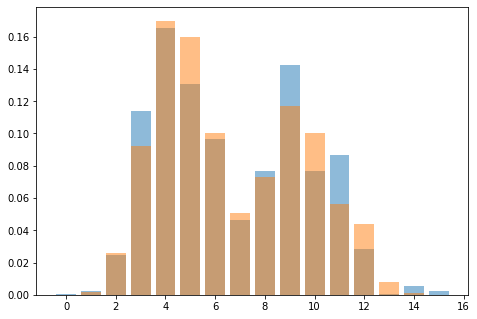

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, generated_data[0], alpha=0.5)
ax.bar(y, new_point, alpha=0.5)
plt.show()